In [2]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation

In [3]:
p = Path("./dataset")

In [4]:
dirs = p.glob("*")

image_data = []
labels = []

image_paths = []

labels_dict = {"Pikachu":0, "Bulbasaur":1, "Meowth":2}
label2pokemon = {0:"Pikachu", 1:"Bulbasaur", 2:"Meowth"}

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1]
    
    cnt = 0
    
    # Iterate over folder_dir and pick all images of the pokemon
    for img_path in folder_dir.glob("*.jpg"):
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (40, 40))
        image_data.append(img)
        labels.append(labels_dict[label])
        cnt += 1  
    
    print(cnt)

176
70
199


In [5]:
X = np.array(image_data)
Y = np.array(labels)

# Normalisation
X = X/255.0

# Create Training and Testing Set
X_ = np.array(X)
Y_ = np.array(Y)

# Training Set
X = X_[:375,:]
Y = Y_[:375]

# Test Set
XTest = X_[375:,:]
YTest = Y_[375:]

X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(375, 4800)
(70, 4800)


## Visualisation of data

In [7]:
# Draw some pokemons
def drawImage(img, label):
    plt.imshow(img)
    plt.axis("off")
    plt.title(label2pokemon[label])
    plt.show()

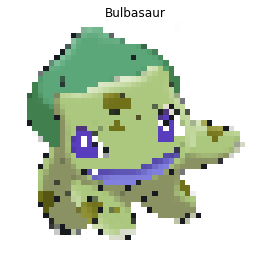

In [8]:
drawImage(X_[0], Y_[0])

## MLP Classifier

In [9]:
class NeuralNetwork:
    
    def __init__(self, input_size, layers, output_size):
        np.random.seed(0)
        
        model = {} # Dictionary
        
        # First Layer
        model['w1'] = np.random.randn(input_size, layers[0]) # randn to generate random weights from a normal distribution
        model['b1'] = np.zeros((1, layers[0]))
        
        # Second Layer
        model['w2'] = np.random.randn(layers[0], layers[1])
        model['b2'] = np.zeros((1, layers[1]))
        
        # Third/Output Layer
        model['w3'] = np.random.randn(layers[1], output_size)
        model['b3'] = np.zeros((1, output_size))
        
        self.model = model
    
    def forward(self, x):
        
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        
        z1 = np.dot(x, w1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1, w2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2, w3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1, a2, y_)
        return y_
        
    def backward(self, x, y, learning_rate=0.001):
        
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        m = x.shape[0]
        a1, a2, y_ = self.activation_outputs
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)/float(m)
        
        delta2 = (1-np.square(a2))*np.dot(delta3, w3.T)
        dw2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)/float(m)
        
        delta1 = (1-np.square(a1))*np.dot(delta2, w2.T)
        dw1 = np.dot(x.T, delta1)
        db1 = np.sum(delta1, axis=0)/float(m)
        
        # Update the model parameters
        self.model["w1"] -= learning_rate*dw1
        self.model["b1"] -= learning_rate*db1
        
        self.model["w2"] -= learning_rate*dw2
        self.model["b2"] -= learning_rate*db2
        
        self.model["w3"] -= learning_rate*dw3
        self.model["b3"] -= learning_rate*db3
        
    def predict(self, x):
        y_out = self.forward(x)
        return np.argmax(y_out, axis=1)
    
    def summary(self):
        
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        a1, a2, y_ = self.activation_outputs
        
        print("w1", w1.shape)
        print("a1", a1.shape)
        
        print("w2", w2.shape)
        print("a2", a2.shape)
        
        print("w3", w3.shape)
        print("y_", y_.shape)
        

In [10]:
def softmax(a):
    e_pa = np.exp(a) # Vector if 'a' is vector
    ans = e_pa / np.sum(e_pa, axis=1, keepdims=True)
    return ans

def loss(y_oht, p):
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y, depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m, depth))
    y_oht[np.arange(m), y] = 1
    return y_oht

## Training our classifier

In [11]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = 3
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        
        model.backward(X,Y_OHT,learning_rate)
        training_loss.append(l)
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,l))        
    
    return training_loss

In [12]:
model = NeuralNetwork(input_size=4800,layers=[100,50],output_size=3)

In [13]:
l = train(X,Y,model,400,0.0002)

Epoch 0 Loss 3.1501
Epoch 50 Loss 0.2196
Epoch 100 Loss 0.0912
Epoch 150 Loss 0.0540
Epoch 200 Loss 0.0381
Epoch 250 Loss 0.0303
Epoch 300 Loss 0.0243
Epoch 350 Loss 0.0200


## Training loss vs Epochs

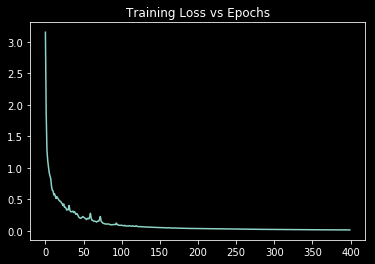

In [14]:
plt.style.use("dark_background")
plt.title("Training Loss vs Epochs")
plt.plot(l)
plt.show()

## Accuracy

In [15]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

In [16]:
print("Train Acc %.4f"%getAccuracy(X,Y,model))
print("Test Acc %.4f"%getAccuracy(XTest,YTest,model))

Train Acc 0.9920
Test Acc 0.6000
